In [2]:
using Gadfly, DataFrames, LightGraphs, StatsBase

# The Imitation Model

* In consideration of the meaning of intelligence, imitation is examined.


* Definition: Intelligence - "the ability to acquire and apply knowledge and skills."

* Definition: Knowledge - "facts, information, and skills acquired by a person through experience or education; the theoretical or practical understanding of a subject."

The idea is that intelligence allows the gathering of knowledge and skills; skills being knowledge stored in structures other than (but still employing the reasoning of) the neocortex i.e. muscles, the endocrine system, etc. 

What about the purpose?

Intelligence minimizes error (where error implies an adverse cost associated with the failure to optimize time collapsed-survival) via the efficient gathering of knowledge and skills.

* Consider Least squares and other techniques that attempt to learn from data.
* Data is all stimuli.
* Your dad, your mom, your TV.
* Polar bears are white

Life imitates other life such that it bypasses an inefficient phase of random trials.

### Error Minimization
Evolution: Generation dependent structural imitation.

Learning: Sub-generational structural imitation based on sensory stimuli.

Problem Solving
1. Recognition of patterns (have I seen this).
   * If so apply learned pattern.
2. Random trials.
   * Apply applicable techniques.
   * Catalog result for later use.

As an exercise try and imagine something that has components not made up of things you have seen, touched, tasted, felt, heard or smelled.

This research explores a model built only on imitation and randomness. 

In [3]:
function imitate(nodes::Int, prob::Float64, moved::Int)
    tot = 0
    for i in 1:(nodes - moved)
        for j in 1:moved
            if prob > rand() 
                tot = tot + 1 
                break
            end 
        end
    end
    tot
end

imitate (generic function with 1 method)

In [37]:
imitate(10, .5, 1)

4

Suppose we have $n$ nodes and $m$ moved. We wish to determine how many nodes will imitate at least one of the $m$ nodes and move themselves. Each node will imitate with probability $p$. The number of nodes available to imitate is $k = n - m$. We can think of each of these $k$ nodes as having $m$ chances to imitate a node that moved:

\begin{equation*}
  X \sim\binom{m}{x}p^x(1-p)^{m-x}
\end{equation*}

A node moves if it imitated at least one of the other nodes:

\begin{equation*}
  P(X \geq 1) = 1 - P(X < 1) = 1 - (1-p)^m = z
\end{equation*}

where $z$ is the probability a node moves. 

The distribution representing the probability that $v$ nodes move is given by:

\begin{equation*}
    V \sim \binom{k}{v}z^v(1-z)^{k-v}
\end{equation*}

Thus we can determine the expected number of nodes that will move:

\begin{equation*}
  \langle V \rangle = k - k(1 - p)^m
\end{equation*}

Note the variance decreases as $p$ increases:

\begin{equation*}
  \sigma^2 = \langle V \rangle(1-p)
\end{equation*}

In [5]:
function expectedMoves(n::Int, p::Float64, m::Int)
    k = n - m
    mean = k - k * (1 - p)^m
    var = mean * (1 - p)
    (mean, var)
end

expectedMoves (generic function with 1 method)

In [6]:
function expectedMovesSim(n::Int, p::Float64, m::Int, trials::Int)
    im = 0
    for i in 1:trials
        im = im + imitate(n, p, m)
    end
    im / trials
end

expectedMovesSim (generic function with 1 method)

In [38]:
n = 50
p = .5
m = 1
expectedMoves(n, p, m)

(24.5,12.25)

In [8]:
expectedMovesSim(n, p, m, 10^6)

24.495611

Let's see what happens as we travel across time. Kick a node some nodes and watch the rest imitate.

In [9]:
function catalyze(nodes::Int, prob::Float64, moved::Int, limit::Int = 10^4; force = true)
    record = [1]
    itr = 1
    while moved > 0 && itr < limit
        moved = imitate(nodes, prob, moved)
        push!(record, moved)
        if force && moved == 0
            moved = 1
        end
        itr = itr + 1
    end
    record
end

catalyze (generic function with 2 methods)

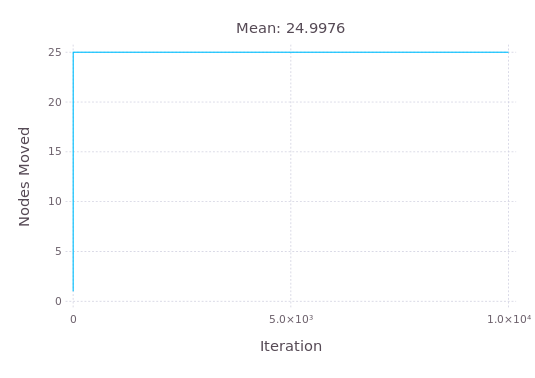

In [56]:
n, p, m = 50, .8, 25
record = catalyze(n, p, m, 10^4, force = false);
plot(x = [x for x = 1:length(record)], y = record, Geom.line,
Guide.ylabel("Nodes Moved"), Guide.xlabel("Iteration"), 
Guide.title("Mean: $(mean(record))"))

In [49]:
expectedMoves(n, p, 25)

(25.0,4.999999999999999)

We can see that for large $p$ the initial condition dictates the outcome whereas smaller values imply a more stochastic process as we expect.

In [12]:
function simulate(folds::Int, totalnodes::Int, numprobs::Int, probstop::Float64)
    analysisnodes::Int = totalnodes - 1
    allmoves = Array{Float64}(analysisnodes, numprobs)
    alltime = Array{Float64}(analysisnodes, numprobs)
    probs = linspace(.01, probstop, numprobs)
    a = 1
    for p in probs, i in 2:totalnodes
        avgmoves = 0
        avgtime = 0
        for j in 1:folds
            record = catalyze(i, p, 1)
            avgmoves = avgmoves + (mean(record))
            avgtime = avgtime + length(record)
        end
        allmoves[a] = avgmoves / folds
        alltime[a] = avgtime / folds
        #print("|$i, $p: $(allmoves[a])")
        a = a + 1
    end
    (allmoves, alltime)
end

simulate (generic function with 1 method)

In [13]:
folds = 10
nodes = 30 
probs = 10
probstop = .99
probvalues = linspace(1//100, probstop, probs)
(moves, time) = simulate(folds, nodes, probs, probstop);

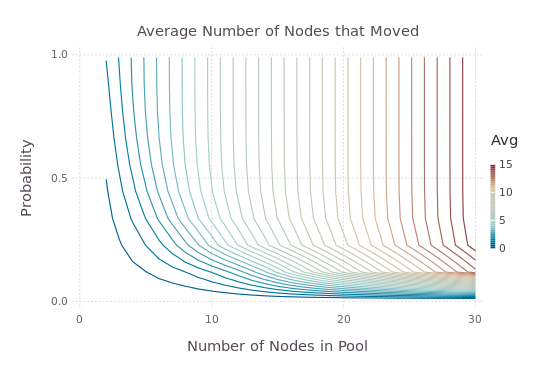

In [14]:
plot(z = moves, x = [x for x = 2:nodes], y = [x for x in probvalues],
Geom.contour(levels=30), Guide.xlabel("Number of Nodes in Pool"), Guide.ylabel("Probability"),
Guide.title("Average Number of Nodes that Moved"), Guide.colorkey("Avg"))

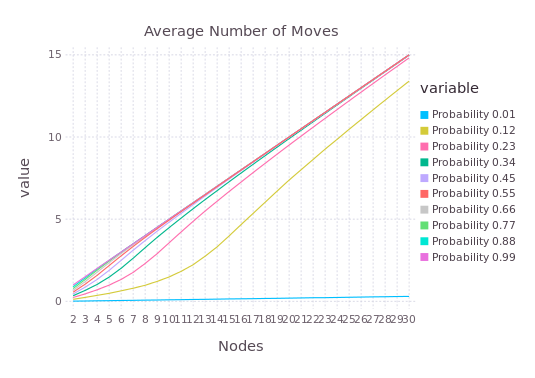

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:38
 in anonymous at no file
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/cfusting/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/cfusting/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[15], in expression starting on line 2


In [15]:
data = DataFrame([2:nodes moves])
names!(data, convert(Array{Symbol, 1}, ["Nodes", [symbol("Probability $x") for x in round(probvalues, 2)]]))
dat = stack(data, [2:probs + 1]);
plot(dat, x = "Nodes", y = "value", color = "variable", Geom.line,
Guide.title("Average Number of Moves"), Stat.xticks(ticks = [x for x = 2:nodes]))

* We find large $p$ values imply steady states expressed as a function of the initial condition. 
* These nodes will likely move forever.

# Let's play a game.

Consider a network where each edge has weight $w \in A = (0,1)$ representing the probability of imitation. 
* We'll kick a node to start the process off.  
* If a node imitates another then the weight is increased by a factor of $\alpha$:

$$e_{ij_{t+1}} = e_{ij_{t}} + \alpha(1 - e_{ij_{t}})$$

* If a node fails to imitate another then the weight is decreased by a factor of $\alpha$:

$$e_{ij_{t+1}} = e_{ij_{t}} - \alpha e_{ij_{t}}$$

In [16]:
"""
Changes the probabalistic weight of the edge between two nodes.
"""
function tenth(W, i, j; strengthen = true)
    if strengthen
        p = W[i,j] + 1/10 * (1 - W[i,j])
    else
        p = W[i,j] - 1/10 * W[i,j]
    end
    #print("New distance $dist\n")
    W[i,j] = p
    W[j,i] = p
end

tenth (generic function with 1 method)

In [17]:
"""
With probabilty of connection `p` generate a random symmetric adjacency matrix of uniformly 
distributed weights between 0 and 1.
"""
function randomweights(n, p, divider) 
    W = zeros(n, n)
    for i in 1:n
        W[i,i] = 0
        for j in i+1:n
            if p > rand()
                r = rand() / divider
                W[i,j] = r
                W[j,i] = r
            end
        end
    end
    W
end

randomweights (generic function with 1 method)

In [18]:
"""
With probabilty of connection `p` create a symmetric adjacency matrix of weights of weight 
`w`.
"""
function staticweights(n, p, w)
    W = zeros(n, n)
    for i in 1:n, j in i+1:n
        if p > rand()
            W[i,j] = w
            W[j,i] = w
        end
    end
    W
end

staticweights (generic function with 1 method)

Consider first the motifs of fully connected nodes.

In [19]:
"""
Get a fully connected network of `n` nodes.
"""
function getperfect(n::Int, p::Float64)
    W = zeros(n, n)
    for i in 1:n
        for j in i+1:n
            W[i,j] = p
            W[j,i] = p
        end
    end
    W
end

getperfect (generic function with 1 method)

In [20]:
getperfect(3,1.0)

3x3 Array{Float64,2}:
 0.0  1.0  1.0
 1.0  0.0  1.0
 1.0  1.0  0.0

In [21]:
"""
Given a symmetric weight matrix `W`, an ordered set of nodes that moved in the previous 
timestep, and a metric defining how to adjust the weights (when `dynamic = true`) evaluate
and return an ordered set of nodes that moved and adjust the weights of `W` accordingly.
"""
function imitate(W, moved, metric; dynamic = true)
    #print("Nodes moved $moved\n")
    n = size(W, 1)
    nodes = setdiff(IntSet(1:n), moved)
    imitated = IntSet()
    for i in nodes, j in moved
        if W[i,j] > rand()
            #print("$i imitated $j\n")
            push!(imitated, i)
            if dynamic metric(W, i, j) end 
        else
            if dynamic metric(W, i, j; strengthen = false) end
        end
    end
    imitated
end

imitate (generic function with 2 methods)

In [22]:
n = 6
p = 1/2
divider = 2
W = randomweights(n, p, divider)
W

6x6 Array{Float64,2}:
 0.0       0.0       0.32947   0.0       0.0       0.199156
 0.0       0.0       0.411344  0.0       0.0       0.0     
 0.32947   0.411344  0.0       0.0       0.0       0.0     
 0.0       0.0       0.0       0.0       0.114506  0.0     
 0.0       0.0       0.0       0.114506  0.0       0.37136 
 0.199156  0.0       0.0       0.0       0.37136   0.0     

In [23]:
nodes = IntSet(sample(collect(1:n), 2, replace = false))

IntSet([3, 4])

In [24]:
nodes = IntSet(sample(collect(1:n), 2, replace = false))
ctr = 1
while length(nodes) > 0 && ctr < 100
    nodes = imitate(W, nodes, tenth)
    ctr = ctr + 1
    #print("nodes : $(length(nodes)), ctr : $ctr \n")
end
triu(W)
W

6x6 Array{Float64,2}:
 0.0       0.0      0.32947  0.0       0.0       0.179241
 0.0       0.0      0.37021  0.0       0.0       0.0     
 0.32947   0.37021  0.0      0.0       0.0       0.0     
 0.0       0.0      0.0      0.0       0.114506  0.0     
 0.0       0.0      0.0      0.114506  0.0       0.37136 
 0.179241  0.0      0.0      0.0       0.37136   0.0     

In [25]:
ctr - 1

1

Things to look at:

* Components $c_i$ 
* nodes $n$
* number of nodes in $c_i \equiv n_{c_i}$
* degree $k$ 
* weights $W$
* distance $D=1-W$


1. How long does an idea bounce around $c_i$ given $k_{avg}$ and $d_{avg}$ (static and dynamic cases)?
2. How does $d_{avg}$ behave as a function of $n_{c_i}$ and $W$

In [42]:
"""
Create an undirected graph without self loops from a weigth matrix.
"""
function graphfromweights(W)
    n = size(W, 1)
    g = Graph(n)
    for i in 1:n, j in i+1:n
        if W[i,j] > 0 
            add_edge!(g, i, j)
        end
    end
    g
end

graphfromweights (generic function with 1 method)

In [43]:
n = 6
p = 1/3
w = 1/2
W = staticweights(n, p, w)

6x6 Array{Float64,2}:
 0.0  0.0  0.5  0.5  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.5  0.5  0.0
 0.5  0.0  0.5  0.0  0.5  0.5
 0.0  0.0  0.5  0.5  0.0  0.0
 0.0  0.0  0.0  0.5  0.0  0.0

In [44]:
g = graphfromweights(W)

{6, 6} undirected graph

In [45]:
degree(g)

6-element Array{Int64,1}:
 2
 0
 3
 4
 2
 1

In [46]:
1 - W

6x6 Array{Float64,2}:
 1.0  1.0  0.5  0.5  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 0.5  1.0  1.0  0.5  0.5  1.0
 0.5  1.0  0.5  1.0  0.5  0.5
 1.0  1.0  0.5  0.5  1.0  1.0
 1.0  1.0  1.0  0.5  1.0  1.0

In [47]:
function visit(node, D, vis, counted, last = 0)
    #print("Visiting node $(node)!\n")
    dist = 0
    for i in 1:size(D, 2)
        if i != last && D[i, node] < 1 
            if !((i, node) in counted)
                push!(counted, (i, node))
                push!(counted, (node, i))
                dist = dist + D[i, node]
            end
            if !(i in vis)
                push!(vis, i)
                dist = dist + visit(i, D, vis, counted, node)
            end
        end
    end 
    dist
end

visit (generic function with 2 methods)

In [48]:
"""
Calculate the total distance between nodes connected to `node` in `W`.
"""
function distance(W, node)
    vis = IntSet()
    counted = Set()
    D = 1 - W
    n = size(D, 2)
    push!(vis, node)
    visit(node, D, vis, counted)
end

distance (generic function with 1 method)

In [49]:
connected_components(g)

2-element Array{Array{Int64,1},1}:
 [1,3,4,5,6]
 [2]        

In [50]:
distance(W, 1)

3.0

In [51]:
type Component
    nodes::Array{Int}
    avgdist::Float64
    avgdeg::Float64
    size::Int
    
    Component(nodes, avgdist, avgdeg) = new(nodes, avgdist, avgdeg, length(nodes))
end

In [52]:
function calccompdist(g, W)
    res = Component[]
    coms = connected_components(g) 
    degrees = degree(g)
    for i in coms
        if length(i) > 1
            avgdeg = mean(degrees[i])
            dist = distance(W, i[1]) / length(i)
            push!(res, Component(i, dist, avgdeg))
        end
    end
    res
end

calccompdist (generic function with 1 method)

In [53]:
coms = calccompdist(g, W)

1-element Array{Component,1}:
 Component([1,3,4,5,6],0.6,2.4,5)

In [54]:
n = 100
p = 1/90
w = 1/2
W = staticweights(n, p, w)
g = graphfromweights(W)
coms = calccompdist(g,W)

15-element Array{Component,1}:
 Component([1,27],0.25,1.0,2)                                                                             
 Component([2,14,25,37,43,46,47,65,67,68],0.45,1.8,10)                                                    
 Component([4,5,15,16,22,29,34,41,42,50,55,75,79,81,82,86,89,90],0.4722222222222222,1.8888888888888888,18)
 Component([6,83],0.25,1.0,2)                                                                             
 Component([9,28,36,59,72,92,93],0.5,2.0,7)                                                               
 Component([12,57,70,84],0.375,1.5,4)                                                                     
 Component([13,73],0.25,1.0,2)                                                                            
 Component([17,66,76],0.3333333333333333,1.3333333333333333,3)                                            
 Component([18,19,60,87,88,95,96,98],0.4375,1.75,8)                                                       
 Compo

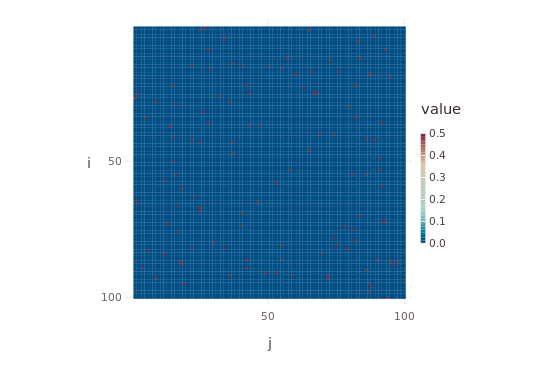

In [55]:
spy(W)

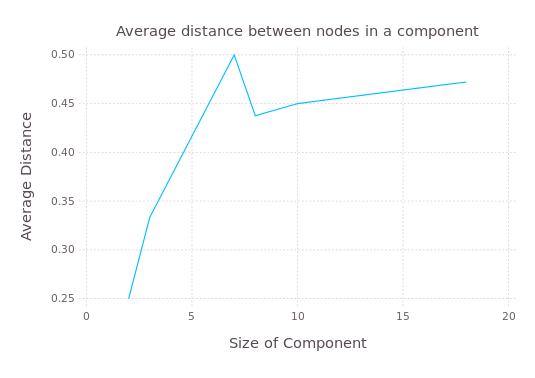

In [56]:
plot(x = [coms[i].size for i = 1:length(coms)], 
y = [coms[i].avgdist for i = 1:length(coms)], 
Guide.xlabel("Size of Component"), Guide.ylabel("Average Distance"),
Guide.title("Average distance between nodes in a component"),
Geom.line)

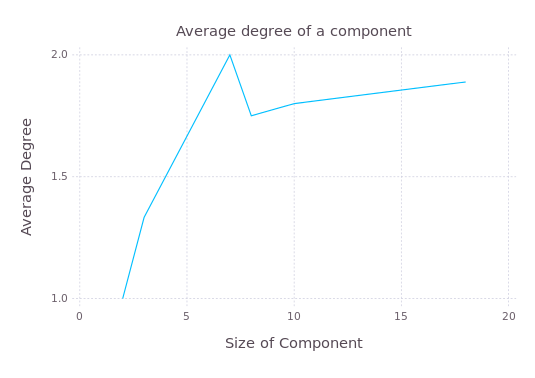

In [57]:
plot(x = [coms[i].size for i = 1:length(coms)], 
y = [coms[i].avgdeg for i = 1:length(coms)], 
Guide.xlabel("Size of Component"), Guide.ylabel("Average Degree"),
Guide.title("Average degree of a component"),
Geom.line)

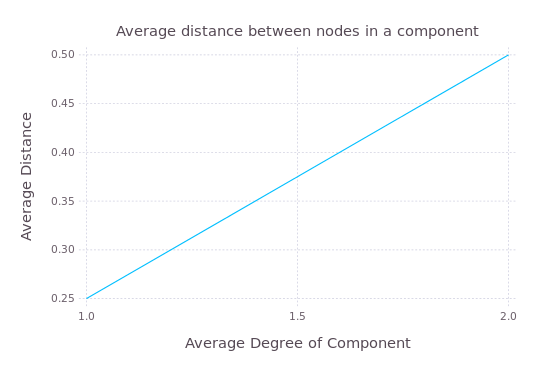

In [58]:
plot(x = [coms[i].avgdeg for i = 1:length(coms)], 
y = [coms[i].avgdist for i = 1:length(coms)], 
Guide.xlabel("Average Degree of Component"), Guide.ylabel("Average Distance"),
Guide.title("Average distance between nodes in a component"),
Geom.line)

In [59]:
using ProgressMeter

In [60]:
move = 10
ctr = 1
itr = 10^6
p = Progress(itr, 1)
while ctr < itr
    if length(nodes) == 0
        nodes = IntSet(sample(collect(1:n), move, replace = false))
    end
    nodes = imitate(W, nodes, tenth)
    ctr = ctr + 1
    next!(p)
end
coms = calccompdist(g, W);

Progress:  99%  ETA: 0:00:01

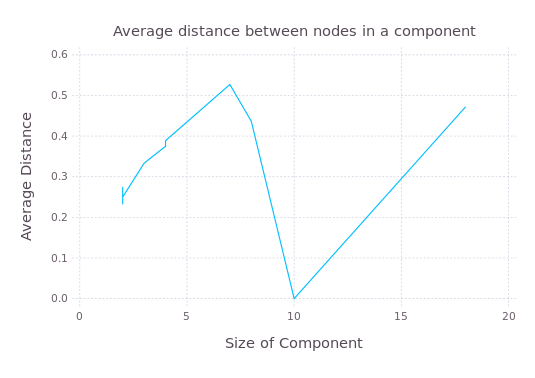

In [61]:
plot(x = [coms[i].size for i = 1:length(coms)], 
y = [coms[i].avgdist for i = 1:length(coms)], 
Guide.xlabel("Size of Component"), Guide.ylabel("Average Distance"),
Guide.title("Average distance between nodes in a component"),
Geom.line)

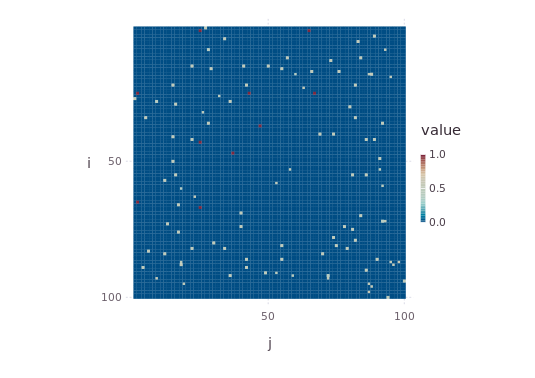

In [62]:
spy(W)

Look at the most simple case: a fully connected graph with static weights.

In [63]:
function meanweight(W)
    tot = 0.0
    ctr = 0
    for i in 1:size(W, 2), j in i+1:size(W, 1)
        tot = tot + W[i,j] 
        ctr = ctr + 1
    end
    tot / ctr
end

meanweight (generic function with 1 method)

In [64]:
function simstaticcomp(n::Int, p::Float64, move::Int = 1, ϵ = 0.001, itr::Int = 10^3)
    W = getperfect(n, p)
    dist = Float64[]
    weights = Array{Float64, 2}[] 
    p = Progress(itr, 1)
    ctr = 1
    emax = 10^2
    ectr = 1
    nodes = []
    ldist = 1
    while ctr <= itr && ectr <= emax
        if length(nodes) == 0
            nodes = IntSet(sample(collect(1:n), move, replace = false))
            #print(nodes,"\n")
        end
        nodes = imitate(W, nodes, tenth)
        push!(weights, copy(W))
        cdist = meanweight(W)
        push!(dist, cdist)
        #print("ldist: $ldist | cdist: $cdist\n")
        if abs(ldist - cdist) < ϵ
            ectr = ectr + 1
        end
        ldist = cdist
        ctr = ctr + 1
        next!(p)
    end
    (dist, weights)
end

simstaticcomp (generic function with 4 methods)

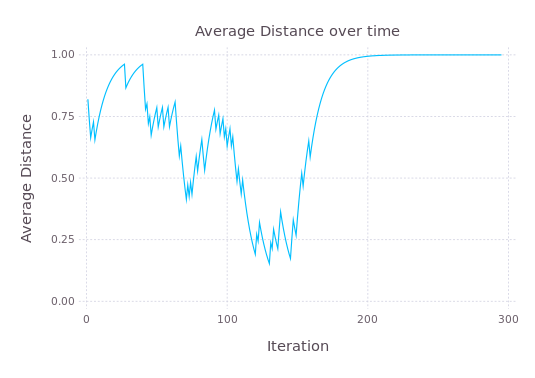

In [65]:
(dist, weights) = simstaticcomp(2, .8);
plot(x = [x for x = 1:length(dist)], 
y = [dist[i] for i = 1:length(dist)], 
Guide.xlabel("Iteration"), Guide.ylabel("Average Distance"),
Guide.title("Average Distance over time"),
Geom.line)

In [66]:
weights[end]

2x2 Array{Float64,2}:
 0.0  1.0
 1.0  0.0

In [67]:
meanweight(W)

0.0059087458161616166

In [68]:
function cleanweights(W, ϵ = .001)
    for i in 1:size(W, 1), j in 1:size(W, 2)
        if W[i,j] < ϵ
            W[i,j] = 0
        elseif W[i,j] > 1 - ϵ
            W[i,j] = 1
        end
    end
end

cleanweights (generic function with 2 methods)

In [69]:
function getdistmotifs(n, p, itr = 10^2)
    motifs = Set{Array{Float64, 2}}()
    for i in 1:itr
        (dist, weights) = simstaticcomp(n, p)
        W = copy(weights[end])
        cleanweights(W)
        if !(W in motifs) 
            push!(motifs, W)
        end
    end
    motifs
end

getdistmotifs (generic function with 2 methods)

In [70]:
motifs = getdistmotifs(3, .5, 10^4)

Set([
3x3 Array{Float64,2}:
 0.0       0.006345  0.0
 0.006345  0.0       1.0
 0.0       1.0       0.0,

3x3 Array{Float64,2}:
 0.0       1.0  0.250379
 1.0       0.0  0.0     
 0.250379  0.0  0.0     ,

3x3 Array{Float64,2}:
 0.0        0.0  0.0140954
 0.0        0.0  1.0      
 0.0140954  1.0  0.0      ,

3x3 Array{Float64,2}:
 0.0        0.0076749  1.0
 0.0076749  0.0        1.0
 1.0        1.0        0.0,

3x3 Array{Float64,2}:
 0.0  1.0       1.0     
 1.0  0.0       0.386829
 1.0  0.386829  0.0     ,

3x3 Array{Float64,2}:
 0.0       0.297677  1.0
 0.297677  0.0       1.0
 1.0       1.0       0.0,

3x3 Array{Float64,2}:
 0.0         0.0  0.00955345
 0.0         0.0  0.0       
 0.00955345  0.0  0.0       ,

3x3 Array{Float64,2}:
 0.0         1.0  0.00174917
 1.0         0.0  0.0       
 0.00174917  0.0  0.0       ,

3x3 Array{Float64,2}:
 0.0        0.0  0.0301398
 0.0        0.0  1.0      
 0.0301398  1.0  0.0      ,

3x3 Array{Float64,2}:
 0.0        1.0  0.0939539
 1.0        

In [71]:
"""
Begin with a seed weight matrix `W`.
"""
function simweights(W::Array{Float64, 2}, move::Int = 1, itr::Int = 10^5)
    dist = Float64[]
    weights = Array{Float64, 2}[] 
    p = Progress(itr, 1)
    ctr = 1
    nodes = []
    ldist = 1
    while ctr <= itr
        if length(nodes) == 0
            nodes = IntSet(sample(collect(1:n), move, replace = false))
            #print(nodes,"\n")
        end
        nodes = imitate(W, nodes, tenth)
        push!(weights, copy(W))
        cdist = meanweight(W)
        push!(dist, cdist)
        #print("ldist: $ldist | cdist: $cdist\n")
        ldist = cdist
        ctr = ctr + 1
        next!(p)
    end
    (dist, weights)
end

simweights (generic function with 3 methods)

In [72]:
m = collect(motifs)
(dist, weights) = simweights(m[6]);

LoadError: LoadError: BoundsError: attempt to access 3x3 Array{Float64,2}:
 0.0       0.297677  1.0
 0.297677  0.0       1.0
 1.0       1.0       0.0
  at index [1,28]
while loading In[72], in expression starting on line 2

Sanity check the thing actually converged..

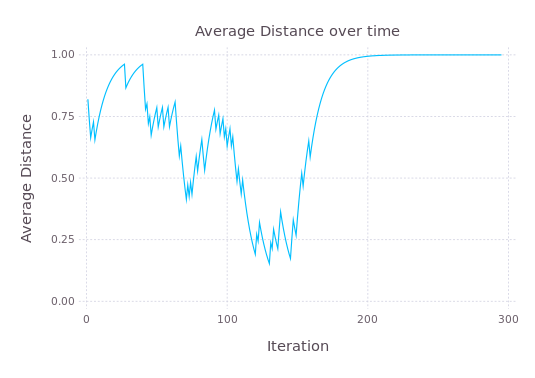

In [73]:
plot(x = [x for x = 1:length(dist)], 
y = [dist[i] for i = 1:length(dist)], 
Guide.xlabel("Iteration"), Guide.ylabel("Average Distance"),
Guide.title("Average Distance over time"),
Geom.line)

In [ ]:
prob = collect(.025:.025:1)
n = 2
plot(x = [x for x in prob], y = [length(getdistmotifs(n, x)) for x in prob],
Guide.xlabel("Probability"), Guide.ylabel("Number of Motifs"),
Guide.title("Weight Motif Frequency"),
Geom.line)